In [3]:
import numpy as np
import cv2
import pims
from tqdm.notebook import trange

import matplotlib.pyplot as plt
from matplotlib.pyplot import plot

import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)3260416/45929032 bytes (7.1%)6807552/45929032 bytes (14.8%)10567680/45929032 bytes (23.0%)14213120/45929032 bytes (30.9%)17899520/45929032 bytes (39.0%)21561344/45929032 bytes (46.9%)25223168/45929032 bytes (54.9%)29040640/45929032 bytes (63.2%)32645120/45929032 bytes (71.1%)35594240/45929032 bytes (77.5%)39215104/45929032 bytes (85.4%)42565632/45929032 bytes (92.7%)

In [2]:
!pip install pims
!python --version

     |████████████████████████████████| 92kB 6.4MB/s 
  Created wheel for pims: filename=PIMS-0.5-cp37-none-any.whl size=84328 sha256=45a6480a72b495441a5033d2dc3776f9c3cb205ddd382b34129291482f1b0bab
  Stored in directory: /root/.cache/pip/wheels/0e/0a/14/4c33a4cc1b9158e57329a38e8e3e03901ed24060eb322d5462
Successfully built pims


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#resolution and labels

# TESLA resolution
#W = 1280
#H = 960

# COMMA.AI resolution
#W = 1164
#H = 874

# low resolutions (to avoid low memory problems)
W = 640
H = 480

# this was used for slam
#W = 1920//2
#H = 1080//2

LABEL_DICT = {0: "no crossroad", 1: "crossroad"}

In [16]:
# Get data from files
def get_data(video_path, log_path):
  with open(log_path, "r") as log_file:
    labels = log_file.read().split("\n")[:-1]
    log_file.close()
  print("Log file read")

  # TODO: check nvidia's nvvl [ https://github.com/NVIDIA/nvvl ] [ https://github.com/mitmul/pynvvl ]
  # make a Video Object instead of loading all frames in memory
  # to access frames just do: frame = frames[n]
  print("Extracting frames ...")
  frames = pims.Video(video_path, format="mp4")
  print("Done extracting frames")

  return frames, np.array(labels).astype(np.int)

video_path = "/content/drive/MyDrive/OpenCRD_dataset/city_1.mp4"  # CHANGE THIS
log_path = video_path[:-4] + ".txt"

frames, labels = get_data(video_path, log_path)

Log file read
Extracting frames ...
Done extracting frames


crossroad


Frame([[[153, 152, 155],
        [154, 153, 156],
        [153, 152, 155],
        ...,
        [ 27,  25,  23],
        [ 27,  25,  23],
        [ 27,  25,  23]],

       [[153, 152, 155],
        [153, 152, 155],
        [153, 152, 155],
        ...,
        [ 10,   8,   6],
        [ 10,   8,   6],
        [ 10,   8,   6]],

       [[153, 152, 155],
        [153, 152, 155],
        [153, 152, 155],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       ...,

       [[125, 120, 122],
        [125, 120, 122],
        [125, 120, 122],
        ...,
        [126, 124, 125],
        [128, 123, 125],
        [128, 123, 125]],

       [[125, 120, 122],
        [125, 120, 122],
        [125, 120, 122],
        ...,
        [126, 124, 125],
        [128, 123, 125],
        [128, 123, 125]],

       [[125, 120, 122],
        [125, 120, 122],
        [125, 120, 122],
        ...,
        [126, 124, 125],
        [128, 123, 125],
        [128, 123, 125]]], dtype=uint8)
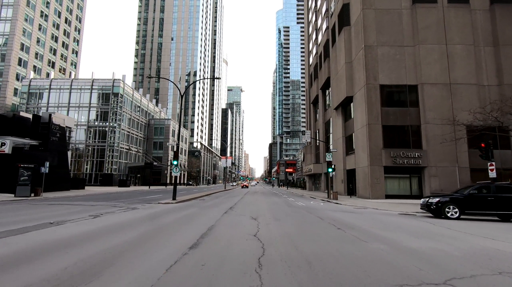

In [17]:
frames.frame_shape
print(LABEL_DICT[labels[800]])
frames[800]

In [86]:
# NOTE: if we cannot get good loss/accuracy, then change to 2 classes ([1,0]: no crossroad, [0,1]: crossroad)
# will need to convert data as well (use a script)
class ConvNet(nn.Module):
  def __init__(self):
    super(ConvNet, self).__init__()

    # image size
    self.W = W
    self.H = H

    # Convolutional Layers
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)

    # Fully connected layers
    #self.fc1 = nn.Linear(16 * W * H, 120)
    self.fc1 = nn.Linear(16 * 117 * 157, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 1)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    #x = x.view(-1, self.num_flat_features(x))
    #x = x.view(-1, 16 * W * H)
    x = x.view(-1, 16 * 117 * 157)
    x = F.relu(self.fc1(x)) # TODO:  mat1 and mat2 shapes cannot be multiplied (1x293904 and 4915200x120), FIX IT
    x = F.relu(self.fc2(x))
    x = F.sigmoid(self.fc3(x))  # sigmoid for binary classification

    return x
  
  # TODO: this doesn't work correctly
  def num_flat_features(self, x):
    size = x.size()[1:] # all dimensions except the batch dimension
    num_features = 1
    for s in size:
      num_features *= s
    return num_features


In [87]:
# TODO: need to train with new data (generally more data), all predicted values are 0
# NOTE: either combine all videos/logs or save the model and retrain on new data

# train the network
def train(frames, labels, model):
  loss_function = nn.BCELoss()
  optim = torch.optim.Adam(model.parameters(), lr=0.001)

  losses, accuracies = [], []
  epochs = 5   # TODO: try training with different number of epochs
  BS = 16        # TODO: try training with different batch sizes (careful with memory)

  t = trange(0, int(0.8 * len(frames)) - BS, BS)  # trange progress bar on 80% training split

  # TODO: losses and accuracies are binary (they swap), SOLVE THIS PROBLEM
  for epoch in range(epochs):
    print("[+] Epoch", epoch)
    #running_loss = 0.0

    # train split = 80%
    for i in t:
      # get data into network

      ## for BS = 1
      #X_train = cv2.resize(cv2.cvtColor(frames[i], cv2.COLOR_BGR2RGB), (W,H))
      #X_train = np.moveaxis(X_train, -1, 0)
      #X = torch.tensor(X_train).float().to(device)
      #X = X.unsqueeze(0)
      #Y_train = np.array([[labels[i]]])
      #Y = torch.tensor(Y_train).float().to(device)

      X_train = []
      for j in range(BS):
        frame = cv2.resize(cv2.cvtColor(frames[i+j], cv2.COLOR_BGR2RGB), (W,H))
        frame = np.moveaxis(frame, -1, 0)
        X_train.append(frame)
      X_train = np.array(X_train)
      X = torch.tensor(X_train).float().to(device)

      Y_train = []
      for j in range(BS):
        Y_train.append([labels[i+j]])
      Y_train = np.array(Y_train)
      Y = torch.tensor(Y_train).float().to(device)

      #model.zero_grad()
      optim.zero_grad()

      # forward feed and backpropagation
      out = model(X)
      cat = torch.round(out)  # TODO: round up to a threshold (0.8 confidence instead of 0.5)
      # NOTE. mean() should be used when we have BS > 1
      accuracy = (cat == Y).float().mean()
      loss = loss_function(out, Y)
      loss = loss.mean()
      loss.backward()
      optim.step()

      # print stats
      loss = loss.item()
      accuracy = accuracy.item()
      losses.append(loss)
      accuracies.append(accuracy)
      t.set_description("loss %.2f accuracy %.2f output %.2f" % (loss, accuracy, out.mean().item()))

  # plot losses and accuracies
  plt.ylim(-0.1, 1.1)
  plot(losses)
  plot(accuracies)

  return model

if device.type == "cuda":
  torch.cuda.empty_cache()  # to avoid running out of cuda memory
  print("[~] Cleared cuda cache")
model = ConvNet().to(device).train() # Uncomment this if you want to train from the start, else just run the loader block first
model = train(frames, labels, model)

[~] Cleared cuda cache


RuntimeError: ignored

In [ ]:
# evaluate model
# TODO: create test data (split the dataset beforehand)
def evaluate(model, X_test, Y_test):
  # prepare data
  X_test = np.moveaxis(X_test, -1, 0)
  Y_test = np.array([[Y_test]])

  X = torch.tensor(X_train).float().to(device)
  X  = X.unsqueeze(0)
  Y = torch.tensor(Y_train).float().to(device)

  # TODO: we are out of RAM
  #Y_test_preds = torch.round(model(torch.tensor(X_test).float().unsqueeze(0).to(device), dim=1).numpy())
  Y_test_preds = []
  for i in trange(int(0.2*len(frames))):
    Y_test_pred = torch.round(model(torch.tensor(X_test[int(0.8*len(frames))+i]).unsqueeze(0).to(device), dim=1).numpy())
    Y_test_preds.append(Y_test_pred)
  Y_test_preds = np.array(Y_test_preds)
  print((Y_test == Y_test_preds).mean())

evaluate(model, frames, labels[int(0.8*len(frames)):])

In [45]:
# save model for later retraining
model_path = "/content/drive/MyDrive/OpenCRD_dataset/models/cr_detector.pth"
torch.save(model.state_dict(), model_path)
print("Model saved to path", model_path)

Model saved to path /content/drive/MyDrive/OpenCRD_dataset/models/cr_detector.pth


In [8]:
# TODO: save/load properly for training with different datasets
# load model for finetuing/retraining
# TODO: write a function to automate the training process for all videos in path

model_path = "/content/drive/MyDrive/OpenCRD_dataset/models/cr_detector.pth"
model = ConvNet()
model.load_state_dict(torch.load(model_path))
model.train()  # for training on new dataset
#model.eval()  # for evaluation
model.to(device)

ConvNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=293904, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=1, bias=True)
)

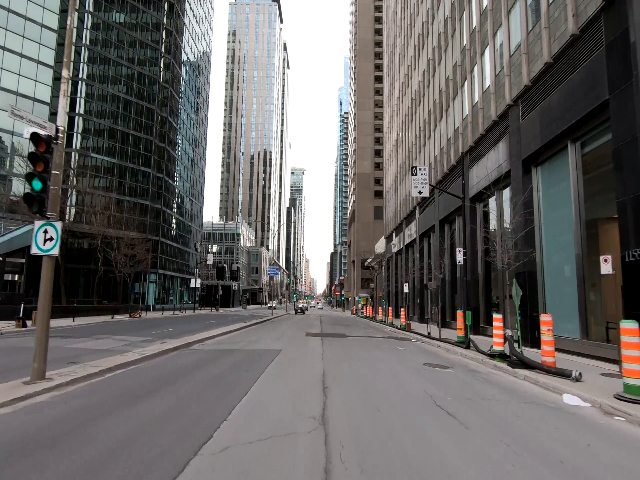

Frame: 500
[+] 0 -> no crossroad
torch.Size([1, 3, 480, 640])
[~] 0.0 -> no crossroad


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [9]:
from google.colab.patches import cv2_imshow

#eval_path = "/content/drive/MyDrive/OpenCRD_dataset/city_2.mp4"
eval_path = "/content/drive/MyDrive/OpenCRD_dataset/city_1.mp4"
log_path = eval_path[:-4] + ".txt"

with open(log_path, "r") as log_file:
  eval_labels = log_file.read().split("\n")[:-1]
  log_file.close()

frames = pims.Video(eval_path, format="mp4")
idx = 500

frame = cv2.resize(cv2.cvtColor(frames[idx], cv2.COLOR_BGR2RGB), (W,H))
cv2_imshow(frame)
print("Frame:", idx)
print("[+]", eval_labels[idx], "->", LABEL_DICT[int(eval_labels[idx])])
    
# forward to model
X_test = np.moveaxis(frame, -1, 0)
X = torch.tensor(X_test).float().to(device)
X = X.unsqueeze(0)
print(X.shape)

Y_pred = model(X)
print("[~]", Y_pred.item(), "->", LABEL_DICT[int(round(Y_pred.item()))])



In [ ]:
# evaluate whole video
cap = cv2.VideoCapture(eval_path)
Y_preds = []

idx = 0
while True:
  ret, frame = cap.read()
  if ret:
    # display frame
    frame = cv2.resize(frame, (W,H))
    cv2_imshow(frame)
    print("Frame:", idx)
    print("[+]", eval_labels[idx], "->", LABEL_DICT[int(eval_labels[idx])])
    

    # forward to model
    X_test = np.moveaxis(frame, -1, 0)
    X = torch.tensor(X_test).float().to(device)
    X = X.unsqueeze(0)
    print(X.shape)

    Y_pred = torch.round(model(X))
    Y_preds.append(Y_pred)
    print("[~]", Y_pred.item())

    if cv2.waitKey(0) & 0xff == ord('q'):
      break
    idx += 1
  else:
    break

#Y_test = np.array([[eval_labels])
#Y_preds = np.array(Y_preds)
#print((Y_test == Y_preds).mean())